## Convert HDDM model object to ArviZ

Author: Hu Chuan-Peng (PhD)

Early trial of converting HDDM to InferenceData.

Contact: hcp4715 AT hotmail.com

We will use the example from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html), and tried to convert the HDDM object to Arviz InferenceData.

So far, I haven't finished the `prior` part and the `log likelihood` part.

Note: to conver the posterior predictive needs substantial amount of memory, make sure that your machine's RAM is large enough.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

The current HDDM version is:  0.8.0


/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


## Loading data

In [4]:
data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


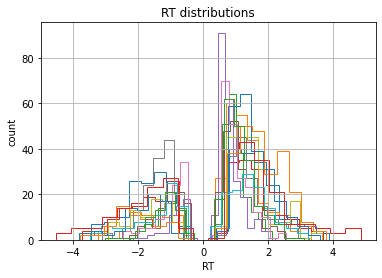

In [7]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [8]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model with four chains

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

Here we tried two approaches for parallel processing, both need to first define a function for stimulus coding.

##### Approach 1: using pathos
Here we will run multiple chains using pathos.

Not finished yet (Wan-Ke: Would you please help me finish this part?)

In [9]:
def parallel(func, *args, show=True, thread=False, **kwargs):
    """
    Parallel processing
    from Wan-Ke Pan, Shanghai Normal Uni, Shanghai, China.
    :param func: 函数，必选参数
    :param args: list/tuple/iterable,1个或多个函数的动态参数，必选参数
    :param show:bool, default is True, whether show the progress.
    :param thread:bool,默认False,是否为多线程
    :param kwargs:1个或多个函数的静态参数，key-word形式
    :return:list,与函数动态参数等长
    """
    import time
    from functools import partial
    from pathos.pools import ProcessPool, ThreadPool
    from tqdm import tqdm
    # 冻结静态参数
    p_func = partial(func, **kwargs)
    # 打开进程/线程池
    pool = ThreadPool() if thread else ProcessPool()
    try:
        if show:
            start = time.time()
            # imap方法
            with tqdm(total=len(args[0]), desc="计算进度") as t:  # 进度条设置
                r = []
                for i in pool.imap(p_func, *args):
                    r.append(i)
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
        else:
          # map方法
          r = pool.map(p_func, *args)
        return r
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state

In [ ]:
df_stim_post_preds = []
for i in range(4):
    m = m_stim_list[i]
    df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('\nchain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)

# delete interim variables to save memory
del m
del df_post_pred

In [10]:
def mult_chain(df, chains=5, **argm):
    """
    mutliple chain in parallel, default samples=5000 burn=2000
    :param df: data
    :param chains: number of chains
    :return:a list of HDDM objects
    """
    import hddm
    # from third_module import parallel
    data_sets = [df] * chains
    def temp(df, **argm):
        import hddm
        m = hddm.HDDM(df, depends_on={'v': 'stim'}, **argm)
        samples = 2000
        burn = 500
        m.find_starting_values()
        m.sample(samples, burn, dbname='multi_chain', db='pickle')
        return m
    ms = parallel(temp, data_sets, **argm)
    # results = hddm.analyze.gelman_rubin(ms)
    return ms

In [11]:
chains = 4
ms = mult_chain(data, chains=chains)

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -                 4%                  ] 96 of 2000 complete in 11.0 sec                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 11 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[        

计算进度: 100%|██████████| 4/4 [04:14<00:00, 63.55s/it, 并行函数=temp, 计算花销=254s] 


In [13]:
r_hat = hddm.analyze.gelman_rubin(ms)
r_hat

{'a': 0.9996666110925848,
 'a_std': 0.9996666110925848,
 'a_subj.0': 0.9996666110925849,
 'a_subj.1': 0.9996666110925848,
 'a_subj.2': 0.9996666110925849,
 'a_subj.3': 0.9996666110925849,
 'a_subj.4': 0.9996666110925849,
 'a_subj.5': 0.9996666110925849,
 'a_subj.6': 0.9996666110925848,
 'a_subj.7': 0.9996666110925848,
 'a_subj.8': 0.9996666110925848,
 'a_subj.9': 0.9996666110925849,
 'a_subj.10': 0.9996666110925848,
 'a_subj.11': 0.9996666110925849,
 'a_subj.12': 0.9996666110925848,
 'a_subj.13': 0.9996666110925849,
 'v(LL)': 0.9996666110925848,
 'v(WL)': 0.9996666110925848,
 'v(WW)': 0.9996666110925848,
 'v_std': 0.9996666110925849,
 'v_subj(LL).0': 0.9996666110925848,
 'v_subj(LL).1': 0.9996666110925849,
 'v_subj(LL).2': 0.9996666110925849,
 'v_subj(LL).3': 0.9996666110925848,
 'v_subj(LL).4': 0.9996666110925848,
 'v_subj(LL).5': 0.9996666110925848,
 'v_subj(LL).6': 0.9996666110925849,
 'v_subj(LL).7': 0.9996666110925849,
 'v_subj(LL).8': 0.9996666110925849,
 'v_subj(LL).9': 0.999666

In [14]:
ms[0].dic

10788.395717238109

In [20]:
def post_pred_par(m, samples, **kwargs):
    import hddm
    ppc = hddm.utils.post_pred_gen(m, samples = 1500)
    
    return ppc

In [21]:
df_ppc = parallel(post_pred_par, [m]*4, samples=1500)

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 18.1 sec[---               9%                  ] 4 of 42 complete in 18.2 sec[---               9%                  ] 4 of 42 complete in 18.2 sec[---               9%                  ] 4 of 42 complete in 18.3 sec[----             11%                  ] 5 of 42 complete in 36.0 sec[----             11%                  ] 5 of 42 complete in 36.2 sec[----             11%                  ] 5 of 42 complete in 36.2 sec[----             11%                  ] 5 of 42 complete in 36.4 sec[-----            14%                  ] 6 of 42 complete in 53.1 sec[-----            14%                  ] 6 of 42 complete in 53.1 sec[-----            14%                  ] 6 of 42 complete in 53.2 sec[-----            14%                  ] 6 of 42 complete in 53.5 sec[------           16%                  ] 7 of 42 complete in 71.9 sec[------           16%                  ] 7 of 42 complete in 72.0 sec[------           16%            

计算进度: 100%|██████████| 4/4 [13:12<00:00, 198.19s/it, 并行函数=post_pred_par, 计算花销=792s]


In [22]:
df_ppc[0].head()

rt  response
node       sample                      
wfpt(LL).0 0      0  3.301191       1.0
                  1  0.750291       1.0
                  2 -1.553191       0.0
                  3 -2.990291       0.0
                  4 -1.406191       0.0

In [31]:
df_stim_post_preds = []
for i in range(4):
    ppc = df_ppc[i]
#     df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
    ppc.reset_index(inplace=True)
    ppc['chain'] = i
    ppc.rename(columns={'sample':'draw',
                        'level_2':'trial'}, inplace=True)
    print('\nchain', i, ppc.shape)
    df_stim_post_preds.append(ppc)

# delete interim variables to save memory
# del m
# del df_post_pred


chain 0 (5982000, 6)

chain 1 (5982000, 6)

chain 2 (5982000, 6)

chain 3 (5982000, 6)


In [32]:
df_stim_post_preds[0].head()

,node,draw,trial,rt,response,chain
0,wfpt(LL).0,0,0,3.301191,1.0,0
1,wfpt(LL).0,0,1,0.750291,1.0,0
2,wfpt(LL).0,0,2,-1.553191,0.0,0
3,wfpt(LL).0,0,3,-2.990291,0.0,0
4,wfpt(LL).0,0,4,-1.406191,0.0,0


##### Approach 2: Using `ipyparallel`
This is the approach I used in my data analyses. The annoying part is that I can not partially fix the `df` as input.

In [8]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [9]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(2000, burn=500,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [10]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
255.542s elapsed

running model (depends on stim) 0
 [-----------------96%----------------  ] 1930 of 2000 complete in 251.4 sec
running model (depends on stim) 1
 [-----------------98%----------------- ] 1965 of 2000 complete in 251.8 sec
running model (depends on stim) 2
 [-----------------96%----------------  ] 1925 of 2000 complete in 251.1 sec
running model (depends on stim) 3
 [-----------------98%----------------- ] 1967 of 2000 complete in 251.4 sec

Running 4 chains used: 270.558898 seconds.


In [16]:
# # Uncomment the code below if you already stored the model objects:
# m_stim_list = []
# exp_name = 'cavanagh'
# model_tag = 'm'
# for i in range(4):
#     mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%i 
#     print(mname)
#     m = hddm.load(mname)
#     m_stim_list.append(m)

/home/jovyan/hddm/temp/df_cavanagh_m_chain_0
/home/jovyan/hddm/temp/df_cavanagh_m_chain_1
/home/jovyan/hddm/temp/df_cavanagh_m_chain_2
/home/jovyan/hddm/temp/df_cavanagh_m_chain_3


#### Prepare the posterior predictive

Need to be parallalized in the future. (**Wan-Ke, do you think we can parallalizing this?**)

* Note 1: the number of sample is consistent with posterior
* Note 2: this part eats a lot of memory, keep the number of sample small at beginning.

In [18]:
df_stim_post_preds = []
for i in range(4):
    m = m_stim_list[i]
    df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('\nchain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)

# delete interim variables to save memory
del m
del df_post_pred

 [------------------107%------------------] 45 of 42 complete in 725.4 sec
chain 0 (5982000, 6)
 [--------         21%                  ] 9 of 42 complete in 102.3 sec

KeyboardInterrupt: 

### Understand the log-likelihood of HDDM

#### First, figure out how the `DIC` is calculated

##### `DIC`'s formula as describe in Wieckie et al (2013) ?

Actually, there is no formula for DIC in that paper, only a reference to Speigelhalter et a., 2019 was give.

##### `DIC`'s common formula (Student's Guide)

$$ DIC = 2 * \widehat {elpd_{DIC}} $$
$$\widehat {elpd_{DIC}} = log[(y | \hat{\theta}_{Bayes})] - k_{DIC}$$
$$ k_{DIC} = 2var_{posterior}(log[p(y | \theta)]$$


##### How `DIC` is calculated in the HDDM script:

In `HDDM` the `DIC` information is calcuated by referring the `dic_info()` function, which is define @L665 in the kabuki/hierarchical.py. In this piece of code, it used the `DIC` function from `MCMC` object of `pymc2`. 

In the `pymc2`'s script (pymc/MCMC.py), we can find `_calc_dic` @L419, where the `DIC` is calculated from two variables: `mean_deviance` and `self.deviance`.

`self.deviance` is a property of `MCMC` model object, which was defined as `-2 * sum[v.get_logp() for v in self.observed_stochastics])` [@L219 of the pymc/Model.py](https://github.com/pymc-devs/pymc/blob/6b1b51ddea1a74c50d9a027741252b30810b29e0/pymc/Model.py#L219).

`mean_deviance = np.mean(self.db.trace('deviance')(). axis=0)`

`dic` is `2* mean_deviance - self.deviance`


**Here is the unsolved issues:**

* `mean_deviance` is the mean from `tmp.mc.db.trace('deviance')()`, if the `deviance` in the trace is defined as in @L842 in `pymc2/Model.py`, then, it uses `_sum_deviance()`, which used the `-2*sum([v.get_logp() for v in self.observed_stochastic])`. However, `self.observed_stochastic` has 42 elements, each is a `wtfp` distribution object, `tmp.mc.db.trace('deviance')` has 1500 elements, which is the same as MCMC sample. So, it seems to me that `tmp.mc.db.trace('deviance')` and the loglikelihood calculated from `self.observed_stochastic` is differnt.

* `logp` is determined by `wftp_like`?

#### Second, compare `DIC` and `WAIC`

##### `WAIC` in Student's guide:

We consider each of the $n$ data points separately. Consider a single data point $y_i$, we can take the log of the average value of the likelihood across the posterior distribution:

$\widehat{lpd} = log[E_{posterior} (p(y_i | \theta))]$

Where $E_{posterior}$ is the expectation with respect to the posterior distribution. If we sum corresponding terms for each of the $n$ points, and include a bias correction term, we obtain an estimate of the expected log pointwise predicitive density (*elppd*):

$\widehat{elppd} = \sum_{i=1}^{n} log[E_{postereior}(p(y_i | \theta))] - k_{WAIC}$

where:

$k_{WAIC} = \sum_{i=1}^{n} var_{posterior}(log p(y_i | \theta))$.

$WAIC = -2 * \widehat{elppd}$


`log_likelihood` in `ArviZ` is the pointwise loglikelihood, where the `Samples` should match with `posterior` ones (1500 in this case) and its variable should match `observed_data` variable (42 = 14 * 3) in this case. which means, for each sample (totally 1500), we can calculate the likelihood for each data point (14 * 3 * 1500 arrays, the length of each array depends on the number of data points there).

Differences between `logp` in `DIC` and `point-wise log-likelihood` (which uses `pdf` function) in `WAIC` or `loo`:

In the student's guide to Bayesian statistics, point-wise likelihood is the log-likelihood for each data point across all posterior samples (page 393).

```
for (i in 1:N){
    loglikelihood[i] = normal_lpdf(X[i] | mu, sigma);
    }
```

What is a `observed_stochastics` variable? It is a type of `container` (pymc/Container.py [@L298](https://github.com/pymc-devs/pymc/blob/master/pymc/Container.py#L298))

      observed_stochastics : set
      All the stochastics self contains with observed=True.

We first get a HDDM model object:

In [33]:
tmp = m_stim_list[0]
tmp.dic

10788.126375121641

Check the black box of this model object, 

In [334]:
tmp.mc.nodes # what is this?

{<pymc.distributions.new_dist_class.<locals>.new_class 'a' at 0x7f08a68efe50>,
 <pymc.PyMCObjects.Deterministic 'a_rate' at 0x7f08a68efa10>,
 <pymc.PyMCObjects.Deterministic 'a_shape' at 0x7f08a5f446d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_std' at 0x7f08a68effd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.0' at 0x7f08a5d92e10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.1' at 0x7f08a5d92910>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.10' at 0x7f08a5d35a50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.11' at 0x7f08a5d35f10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.12' at 0x7f08a5d35590>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f08a5d35dd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.2' at 0x7f08a5f8c690>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.3' at 0x7f08a5f8c890>,
 <pymc.distributions.

In [331]:
tmp.mc.stochastics

{<pymc.distributions.new_dist_class.<locals>.new_class 'a_std' at 0x7f08a68effd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(WW).11' at 0x7f08a5cc9f10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(WL).4' at 0x7f08a5cf9f10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.11' at 0x7f08a5d35f10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LL).7' at 0x7f08a5d53ed0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(WL).12' at 0x7f08a5d25e90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a' at 0x7f08a68efe50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 't' at 0x7f08a5e8ddd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LL).0' at 0x7f08a5d53dd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f08a5d35dd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LL).6' at 0x7f08a5d53c90>,
 <pymc.distributions.new_dist_class.<locals

In [337]:
tmp.mc.deterministics

{<pymc.PyMCObjects.Deterministic 't_shape' at 0x7f08a5ec3390>,
 <pymc.PyMCObjects.Deterministic 'a_shape' at 0x7f08a5f446d0>,
 <pymc.PyMCObjects.Deterministic 't_rate' at 0x7f08a5f8c610>,
 <pymc.PyMCObjects.Deterministic 'v_tau' at 0x7f08a68efe10>,
 <pymc.PyMCObjects.Deterministic 'a_rate' at 0x7f08a68efa10>}

In [338]:
tmp.mc.potentials

set()

In [339]:
tmp.mc.status

'ready'

In [186]:
tmp.mc.db

In [187]:
tmp.mc.db.trace

<bound method Database.trace of <pymc.database.pickle.Database object at 0x7f08a6435f10>>

In [351]:
tmp.mc.db.variable # what else in the tmp.mc.db other than `trace`?

AttributeError: 'Database' object has no attribute 'variable'

In [352]:
tmp.mc.db.trace('deviance')[:]  # self.deviance ?

array([10723.74798036, 10731.5744248 , 10716.24605852, ...,
       10729.51368093, 10704.70099678, 10708.15231599])

In [353]:
trace_deviance = tmp.mc.db.trace('deviance')[:] 
len(trace_deviance) # this length is equal to samples

1500

In [354]:
mean_deviance = np.mean(tmp.mc.db.trace('deviance')(), axis=0)
mean_deviance

10723.904279421982

In [98]:
tmp.mc.observed_stochastics

{<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).0' at 0x7f08a5c9da90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).1' at 0x7f08a5c407d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).10' at 0x7f08a5c5b790>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).11' at 0x7f08a5c73650>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).12' at 0x7f08a5c73dd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).13' at 0x7f08a5c73fd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).2' at 0x7f08a5c40cd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).3' at 0x7f08a5c406d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).4' at 0x7f08a5c409d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).5' at 0x7f08a5c40250>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LL).6' at 0x7f08a5c5b5d0>,
 <pymc.distributions.new_dis

Every element in `m.mc.observed_stochastics` is a `pymc.distributions.new_dist_class.<locals>.new_class 'wftp(conditions).subj_indx'`, because it is the `wftp` distribution, it has properties like `pdf`, `logp`.

In [355]:
tmp3 = [v for v in tmp.mc.observed_stochastics] # number of condition multiply number of subj
len(tmp3) # 42 = 14 (subj number) * 3 (conditions)

42

In [147]:
k_dic = -2*sum([v.get_logp() for v in tmp.mc.observed_stochastics])
k_dic # is this the k_dic in the formula above?

10659.682183722323

Here we can reproduce the `tmp.dic` by using the `mean_deviance` and `k_dic`. However, how the `tmp.mc.db.trace('deviance')` is calculated is still myterious to me.

In [356]:
2 * mean_deviance - k_dic

10788.126375121641

We can check the element of `tmp.mc.observed_stochastics`

In [102]:
tmp3[0] # a pymc distribution object

<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(WL).1' at 0x7f08a5c73810>

In [105]:
tmp3[0].parents

{'p_outlier': 0.05,
 'v': <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(WL).1' at 0x7f08a5cf9390>,
 'sv': 0,
 'a': <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.1' at 0x7f08a5d92910>,
 'z': 0.5,
 'sz': 0,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.1' at 0x7f08a5f444d0>,
 'st': 0}

In [299]:
tmp3[0].parents.value

{'v': array(0.99686249),
 'a': array(2.15281965),
 't': array(0.39572388),
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [348]:
tmp3[1].parents.value

{'v': array(0.95894862),
 'a': array(2.53264049),
 't': array(0.60812482),
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [154]:
tmp3[0].children # reaction time and response?

{<pymc.PyMCObjects.Deterministic '(wfpt(WL).11_lt_wfpt(WL).1)' at 0x7f07bc3be990>,
 <pymc.PyMCObjects.Deterministic 'wfpt(WL).1[0]' at 0x7f07bc3d3ed0>}

Here we found that `logp` gives one number. Also myterious how does this number come from.

In [218]:
tmp3[0].logp

-164.74837078447754

In [107]:
tmp3[0].random

<bound method generate_wfpt_stochastic_class.<locals>.random of <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(WL).1' at 0x7f08a5c73810>>

In [202]:
tmp3[0].random() # This is not the rawdata, instead, it created random dataset based 
                 # on parents' value

,rt,response
0,1.973724,1.0
1,1.400724,1.0
2,0.581624,1.0
3,1.082224,1.0
4,0.972324,1.0
...,...,...
148,0.925424,1.0
149,-1.083924,0.0
150,-1.136024,0.0
151,1.313124,1.0


In [267]:
type(tmp3[0].value) # this is the raw data!!!

pandas.core.frame.DataFrame

In [255]:
data['rt'][(data['subj_idx'] ==1) & (data['stim'] == 'WL')]

298    1.510
299    0.670
302    0.722
303    0.931
305    1.360
       ...  
587    0.784
589    1.320
591   -0.964
593    1.260
594    1.100
Name: rt, Length: 153, dtype: float64

In [286]:
tmp3[0].value['rt'].to_numpy()

array([ 1.51 ,  0.67 ,  0.722,  0.931,  1.36 ,  1.56 ,  1.69 ,  1.85 ,
        0.757,  0.846,  2.47 ,  1.3  ,  1.49 ,  0.826,  2.74 ,  0.641,
        0.676,  1.62 ,  0.976,  1.36 ,  1.03 , -0.709,  0.661,  0.992,
       -1.69 ,  0.901,  1.69 ,  0.865, -1.74 ,  1.52 ,  1.42 ,  2.12 ,
        3.03 ,  1.45 ,  1.15 , -1.13 ,  1.26 ,  0.81 ,  1.52 ,  0.769,
        1.04 ,  2.8  ,  0.953,  1.72 ,  1.22 ,  1.29 ,  1.42 ,  0.975,
        1.68 ,  1.92 ,  1.23 , -3.02 ,  2.06 ,  0.657,  1.23 ,  1.29 ,
        0.657,  0.713,  0.956,  2.43 , -2.   ,  2.46 ,  1.38 ,  1.35 ,
        0.741,  1.06 ,  0.961,  2.13 , -1.3  ,  1.27 ,  1.41 ,  1.49 ,
        0.505,  0.898,  0.921,  1.39 ,  2.41 ,  1.4  ,  1.21 ,  1.11 ,
        0.624,  1.45 ,  0.673,  1.53 ,  1.14 ,  1.09 , -2.13 ,  1.07 ,
        1.36 ,  1.23 ,  1.85 ,  0.796,  0.893,  1.44 ,  1.46 ,  2.37 ,
        0.538, -1.5  ,  1.05 ,  0.7  ,  1.08 ,  0.731,  0.866,  1.08 ,
        0.598, -2.32 ,  0.967,  1.47 ,  1.41 ,  0.998,  1.16 ,  0.67 ,
      

We can use `pdf` to get each data point's likelihood and log them, but this result is differnt from `tmp3[0].logp` (-164.7483707). This needs further investigation, @hddm/likelihoods.py #L21.

Here, the `tmp3[0].pdf()` take numpy array as input, all these data should be RT, with positive and negative sign, and return one likelihood. We can change the theta by changing the `parents`' value of `tmp3[0]`.

In [109]:
tmp3[0].pdf   # #/hddm/likelihoods.py

<bound method generate_wfpt_stochastic_class.<locals>.pdf of <pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(WL).1' at 0x7f08a5c73810>>

In [363]:
tmp3[0].pdf(np.array([-1.0]))

array([0.08421273])

In [361]:
pw_lik = tmp3[0].pdf(tmp3[0].value['rt'].to_numpy()) # get the pdf of each data point over what
pw_loglik = np.log(pw_lik)
print(np.sum(pw_loglik))
print(np.mean(pw_loglik))

-171.52809607139253
-1.1210986671332845


In [307]:
tmp7 = tmp3[0].parents.value
tmp7

{'v': array(0.99686249),
 'a': array(2.15281965),
 't': array(0.39572388),
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

hddm/likelihoods.py #L84 defined the pdf:

```
    #create pdf function
    def pdf(self, x):
        out = hddm.wfpt.pdf_array(x, **self.parents)
        return out
```

Can we change the parents's value directly?

In [308]:
tmp8 = {'v': 0.99686249,
 'a': 2.15281965,
 't': 0.39572388,
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [309]:
tmp3[0].pdf(tmp4, tmp8)

TypeError: pdf() takes 2 positional arguments but 3 were given

We can set the parents' value by using the code below!!!

In [365]:
tmp3[0].parents = tmp8

In [366]:
tmp3[0].pdf(np.array([-1.0]))

array([0.08421273])

In [369]:
tmp9 = {'v': 1.50,
 'a': 2.0,
 't': 0.3,
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [ ]:
tmp3[0].parents = tmp9
tmp3[0].pdf(np.array([-1.0]))

In [372]:
tmp3[1].pdf(np.array([-1.0]))

array([0.06269753])

In [377]:
tmp3[1].parents.value

{'v': array(0.95894862),
 'a': array(2.53264049),
 't': array(0.60812482),
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [378]:
tmp3[0].parents = tmp3[1].parents.value
tmp3[0].pdf(np.array([-1.0]))

array([0.06269753])

Can we use the `wfpt`'s pdf function directly?

In [380]:
from hddm import wfpt

In [389]:
wfpt

<module 'wfpt' from '/opt/conda/lib/python3.7/site-packages/wfpt.cpython-37m-x86_64-linux-gnu.so'>

In [408]:
wfpt.pdf_array(x = np.array([-1.0]), 
               v = np.array([0.95894862]),
               a = np.array([2.53264049]), 
               t = np.array([0.60812482]),
               p_outlier = 0.05,
               sv = 0,
               z = 0.5,
               sz = 0,
               st = 0)

array([0.06269753])

In [409]:
tmp3[2]

<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(WW).0' at 0x7f08a5bc98d0>

In [411]:
tmp3[2].pdf(np.array([-1.]))

array([0.31949152])

In [412]:
tmp3[2].parents.value

{'v': array(0.10327876),
 'a': array(2.20477618),
 't': array(0.55170328),
 'p_outlier': 0.05,
 'sv': 0,
 'z': 0.5,
 'sz': 0,
 'st': 0}

In [413]:
wfpt.pdf_array(x = np.array([-1.0]), 
               v = np.array([0.10327876]),
               a = np.array([2.20477618]), 
               t = np.array([0.55170328]),
               p_outlier = 0.05,
               sv = 0,
               z = 0.5,
               sz = 0,
               st = 0)

array([0.31949152])

#### Let's try to get the `point-wise log-likelihood` of the data

What we need to do is, for each data point, we need to calculate it's log-likelihood given each sample of posterior. Because we can use `wfpt.pdf_array` directly, we can start with posterior and loop it

* Step 1: Get the posterior of each sample (subject level)
* Step 2: Record it's condition
* Step 3: Calculate the pdf
* Step 4: log
* Step 5: Record the results.

The issue here is, what does `point-wise` mean in a hirarchcial model? Here I tried on trial-level, but go nan because there are differnt number of trial for different conditions.

In [416]:
# get posterior
tmp_posterior = tmp.get_traces()
print(tmp_posterior.shape)
tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
tmp_posterior.head()

(1500, 78)


,a,a_std,a_subj.0,a_subj.1,a_subj.2,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.7,...,t_subj.5,t_subj.6,t_subj.7,t_subj.8,t_subj.9,t_subj.10,t_subj.11,t_subj.12,t_subj.13,samples
0,2.076638,0.415963,2.332947,2.249350,1.590860,2.129550,1.579456,1.724346,1.598972,1.743645,...,0.360034,0.429186,0.605748,0.529241,0.348709,0.646786,0.602440,0.402744,0.521331,0
1,2.104152,0.320372,2.318579,2.108443,1.525873,2.158949,1.485712,1.754900,1.567369,1.743145,...,0.360255,0.426080,0.607720,0.529496,0.354925,0.605814,0.610455,0.399542,0.577102,1
2,1.864130,0.371823,2.149233,2.101510,1.603091,2.136436,1.516968,1.776506,1.558653,1.714707,...,0.351616,0.420509,0.620357,0.532592,0.287444,0.657437,0.619659,0.397206,0.542836,2
3,1.889130,0.282430,2.169957,2.191358,1.584113,2.195206,1.519941,1.779552,1.586509,1.811375,...,0.358393,0.429032,0.611028,0.532925,0.331641,0.641198,0.610428,0.426309,0.516694,3
4,2.049181,0.295293,2.189339,2.097973,1.550400,2.200531,1.478444,1.800370,1.590092,1.772898,...,0.354688,0.431506,0.612093,0.578435,0.328829,0.692053,0.615565,0.375066,0.532026,4


In [503]:
tmp_tmp = tmp_posterior.head(5)
tmp_tmp

,a,a_std,a_subj.0,a_subj.1,a_subj.2,a_subj.3,a_subj.4,a_subj.5,a_subj.6,a_subj.7,...,t_subj.5,t_subj.6,t_subj.7,t_subj.8,t_subj.9,t_subj.10,t_subj.11,t_subj.12,t_subj.13,samples
0,2.076638,0.415963,2.332947,2.249350,1.590860,2.129550,1.579456,1.724346,1.598972,1.743645,...,0.360034,0.429186,0.605748,0.529241,0.348709,0.646786,0.602440,0.402744,0.521331,0
1,2.104152,0.320372,2.318579,2.108443,1.525873,2.158949,1.485712,1.754900,1.567369,1.743145,...,0.360255,0.426080,0.607720,0.529496,0.354925,0.605814,0.610455,0.399542,0.577102,1
2,1.864130,0.371823,2.149233,2.101510,1.603091,2.136436,1.516968,1.776506,1.558653,1.714707,...,0.351616,0.420509,0.620357,0.532592,0.287444,0.657437,0.619659,0.397206,0.542836,2
3,1.889130,0.282430,2.169957,2.191358,1.584113,2.195206,1.519941,1.779552,1.586509,1.811375,...,0.358393,0.429032,0.611028,0.532925,0.331641,0.641198,0.610428,0.426309,0.516694,3
4,2.049181,0.295293,2.189339,2.097973,1.550400,2.200531,1.478444,1.800370,1.590092,1.772898,...,0.354688,0.431506,0.612093,0.578435,0.328829,0.692053,0.615565,0.375066,0.532026,4


In [515]:
data_grouped = data.groupby(['subj_idx', 'stim'])

for group_name, df_grouped in data_grouped:
    print("a_subj." + str(group_name[0]))
    print("v_subj(" + group_name[1] + ")." + str(group_name[0]))
    tmp_df =data_grouped.get_group(group_name)
    print(np.array(tmp_df['rt']))
     
#     print(type(group_name[0]))
#     print(type(group_name[1]))
#     print(df_grouped['rt'])

a_subj.0
v_subj(LL).0
[ 1.21   2.     1.72   1.72  -2.44  -0.987 -1.17  -2.84   2.35   1.46
  2.76  -2.15  -1.38   3.17  -3.83  -1.49   0.886  0.968  0.841 -2.87
 -3.66  -0.602 -1.25  -1.98   2.2   -1.93   1.5   -1.65   1.56   1.15
  0.814  1.08  -1.59   2.02   1.36   1.15   2.34   1.23   2.38   2.26
  1.98  -3.52   1.74  -1.98   1.5    2.52   3.82   3.51  -1.17  -3.22
 -3.02  -1.71  -1.02  -1.17  -1.95   1.84  -1.87  -2.31   1.66  -0.935
  1.71  -1.49  -2.03   1.08  -1.45  -0.848  2.01  -1.81   1.2   -1.55
 -1.92  -1.23  -1.16 ]
a_subj.0
v_subj(WL).0
[ 1.63   2.77   1.15  -1.04  -1.5   -0.656  1.36  -1.57  -2.36   1.38
  1.01  -1.01  -1.51   1.05  -3.25   1.53  -1.6    2.74   1.53   0.661
  2.17   0.782 -3.21   1.91   1.48   1.35   1.54   2.24  -2.23  -2.5
  1.65  -1.59  -1.94  -1.83  -0.714  0.632 -2.28  -1.98  -1.89  -2.08
 -0.907  2.19  -1.41  -1.16  -0.947 -1.05  -1.61  -1.92   1.47   0.87
  0.746  1.63   3.37   1.13  -2.03   1.45  -0.965  2.78  -0.994  1.13
  1.11  -1.66  -1.37  

In [531]:
data_grouped = data.groupby(['subj_idx', 'stim'])
df_pll = []
for ii in range(len(m_stim_list)):
    tmp_posterior = m_stim_list[ii].get_traces()
#     print(tmp_posterior.shape)
    tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
    tmp_posterior.head()
    for group_name, df_grouped in data_grouped:
        
        tmp_df =data_grouped.get_group(group_name)
        tmp_df = np.array(tmp_df['rt'])
    #     print(type(tmp_df))

        a_colname = "a_subj." + str(group_name[0])
    #     print(a_colname)
        t_colname = "t_subj." + str(group_name[0])
    #     print(t_colname)
        v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])
    #     print(v_colname)

        for index, row in tmp_posterior.iterrows():
            tmp_a = row[a_colname]
    #         print("a: ", tmp_a)
            tmp_t = row[t_colname]
    #         print("t: ", tmp_t)
            tmp_v = row[v_colname]
    #         print("v: ", tmp_v)

            pw_ll = np.log(wfpt.pdf_array(x = tmp_df,
                                   v = np.array(tmp_v),
                                   a = np.array(tmp_a), 
                                   t = np.array(tmp_t),
                                   p_outlier = 0.05,
                                   sv = 0,
                                   z = 0.5,
                                   sz = 0,
                                   st = 0))
            tmp_df_pll = pd.DataFrame({'pw_ll': pw_ll,
                                       'sample': index,
                                       'subj_idex': group_name[0],
                                       'stim': group_name[1],
                                       'chain': ii})
            df_pll.append(tmp_df_pll)
#         print(pw_ll)
#         print("Another loop of sample\n")
    
#     print(row["a_subj.0"])
df_pll = pd.concat(df_pll)

In [532]:
# df_pll = pd.DataFrame(df_pll)
df_pll.shape

(23928000, 5)

In [534]:
df_pll.rename(columns={'sample': 'draw'}, inplace=True)
df_pll.head()

,pw_ll,draw,subj_idex,stim,chain
0,-1.410612,0,0,LL,0
1,-2.114906,0,0,LL,0
2,-1.859176,0,0,LL,0
3,-1.859176,0,0,LL,0
4,-2.221698,0,0,LL,0


In [536]:
df_pll.rename(columns={'subj_idex': 'subj_idx'}, inplace=True)

In [537]:
df_pll['trial'] = df_pll.groupby(['chain', 'draw', 'subj_idx', 'stim']).cumcount()
df_pll.head()

,pw_ll,draw,subj_idx,stim,chain,trial
0,-1.410612,0,0,LL,0,0
1,-2.114906,0,0,LL,0,1
2,-1.859176,0,0,LL,0,2
3,-1.859176,0,0,LL,0,3
4,-2.221698,0,0,LL,0,4


In [542]:
df_pll.rename(columns={'pw_ll': 'obs'}, inplace=True)

In [543]:
df_pll_ppc = df_pll.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
xdata_loglik = xr.Dataset.from_dataframe(df_pll_ppc)
xdata_loglik

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1500, stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1493 1494 1495 1496 1497 1498 1499
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    obs       (chain, draw, subj_idx, stim, trial) float64 -1.411 -2.115 ... nan

In [576]:
def get_log_likelihood(idata, var_name=None):
    """Retrieve the log likelihood dataarray of a given variable."""
    if (
        not hasattr(idata, "log_likelihood")
        and hasattr(idata, "sample_stats")
        and hasattr(idata.sample_stats, "log_likelihood")
    ):
        warnings.warn(
            "Storing the log_likelihood in sample_stats groups has been deprecated",
            DeprecationWarning,
        )
        return idata.sample_stats.log_likelihood
    if not hasattr(idata, "log_likelihood"):
        raise TypeError("log likelihood not found in inference data object")
    if var_name is None:
        var_names = list(idata.log_likelihood.data_vars)
        if len(var_names) > 1:
            raise TypeError(
                f"Found several log likelihood arrays {var_names}, var_name cannot be None"
            )
        return idata.log_likelihood[var_names[0]]
    else:
        try:
            log_likelihood = idata.log_likelihood[var_name]
        except KeyError as err:
            raise TypeError(f"No log likelihood data named {var_name} found") from err
        return log_likelihood

In [610]:
import functools
def conditional_dask(func):
    """Conditionally pass dask kwargs to `wrap_xarray_ufunc`."""

    @functools.wraps(func)
    def wrapper(*args, **kwargs):

        if Dask.dask_flag:
            user_kwargs = kwargs.pop("dask_kwargs", None)
            if user_kwargs is None:
                user_kwargs = {}
            default_kwargs = Dask.dask_kwargs
            return func(dask_kwargs={**default_kwargs, **user_kwargs}, *args, **kwargs)
        else:
            return func(*args, **kwargs)

    return 

def make_ufunc(
    func, n_dims=2, n_output=1, n_input=1, index=Ellipsis, ravel=True, check_shape=None
):  # noqa: D202
    """Make ufunc from a function taking 1D array input.
    Parameters
    ----------
    func : callable
    n_dims : int, optional
        Number of core dimensions not broadcasted. Dimensions are skipped from the end.
        At minimum n_dims > 0.
    n_output : int, optional
        Select number of results returned by `func`.
        If n_output > 1, ufunc returns a tuple of objects else returns an object.
    n_input : int, optional
        Number of **array** inputs to func, i.e. ``n_input=2`` means that func is called
        with ``func(ary1, ary2, *args, **kwargs)``
    index : int, optional
        Slice ndarray with `index`. Defaults to `Ellipsis`.
    ravel : bool, optional
        If true, ravel the ndarray before calling `func`.
    check_shape: bool, optional
        If false, do not check if the shape of the output is compatible with n_dims and
        n_output. By default, True only for n_input=1. If n_input is larger than 1, the last
        input array is used to check the shape, however, shape checking with multiple inputs
        may not be correct.
    Returns
    -------
    callable
        ufunc wrapper for `func`.
    """
    if n_dims < 1:
        raise TypeError("n_dims must be one or higher.")

    if n_input == 1 and check_shape is None:
        check_shape = True
    elif check_shape is None:
        check_shape = False

    def _ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for single-output function."""
        arys = args[:n_input]
        n_dims_out = None
        if out is None:
            if out_shape is None:
                out = np.empty(arys[-1].shape[:-n_dims])
            else:
                out = np.empty((*arys[-1].shape[:-n_dims], *out_shape))
                n_dims_out = -len(out_shape)
        elif check_shape:
            if out.shape != arys[-1].shape[:-n_dims]:
                msg = f"Shape incorrect for `out`: {out.shape}."
                msg += f" Correct shape is {arys[-1].shape[:-n_dims]}"
                raise TypeError(msg)
        for idx in np.ndindex(out.shape[:n_dims_out]):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            out[idx] = np.asarray(func(*arys_idx, *args[n_input:], **kwargs))[index]
        return out
    
    def _multi_ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for multi-output function."""
        arys = args[:n_input]
        element_shape = arys[-1].shape[:-n_dims]
        if out is None:
            if out_shape is None:
                out = tuple(np.empty(element_shape) for _ in range(n_output))
            else:
                out = tuple(np.empty((*element_shape, *out_shape[i])) for i in range(n_output))

        elif check_shape:
            raise_error = False
            correct_shape = tuple(element_shape for _ in range(n_output))
            if isinstance(out, tuple):
                out_shape = tuple(item.shape for item in out)
                if out_shape != correct_shape:
                    raise_error = True
            else:
                raise_error = True
                out_shape = "not tuple, type={type(out)}"
            if raise_error:
                msg = f"Shapes incorrect for `out`: {out_shape}."
                msg += f" Correct shapes are {correct_shape}"
                raise TypeError(msg)
        for idx in np.ndindex(element_shape):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            results = func(*arys_idx, *args[n_input:], **kwargs)
            for i, res in enumerate(results):
                out[i][idx] = np.asarray(res)[index]
        return out

    if n_output > 1:
        ufunc = _multi_ufunc
    else:
        ufunc = _ufunc

    update_docstring(ufunc, func, n_output)
    return ufunc

@conditional_dask
def wrap_xarray_ufunc(
    ufunc,
    *datasets,
    ufunc_kwargs=None,
    func_args=None,
    func_kwargs=None,
    dask_kwargs=None,
    **kwargs,
):
    """Wrap make_ufunc with xarray.apply_ufunc.
    Parameters
    ----------
    ufunc : callable
    datasets : xarray.dataset
    ufunc_kwargs : dict
        Keyword arguments passed to `make_ufunc`.
            - 'n_dims', int, by default 2
            - 'n_output', int, by default 1
            - 'n_input', int, by default len(datasets)
            - 'index', slice, by default Ellipsis
            - 'ravel', bool, by default True
    func_args : tuple
        Arguments passed to 'ufunc'.
    func_kwargs : dict
        Keyword arguments passed to 'ufunc'.
            - 'out_shape', int, by default None
    dask_kwargs : dict
        Dask related kwargs passed to :func:`xarray:xarray.apply_ufunc`.
        Use :meth:`~arviz.Dask.enable_dask` to set default kwargs.
    **kwargs
        Passed to xarray.apply_ufunc.
    Returns
    -------
    xarray.dataset
    """
    if ufunc_kwargs is None:
        ufunc_kwargs = {}
    ufunc_kwargs.setdefault("n_input", len(datasets))
    if func_args is None:
        func_args = tuple()
    if func_kwargs is None:
        func_kwargs = {}
    if dask_kwargs is None:
        dask_kwargs = {}

    kwargs.setdefault(
        "input_core_dims", tuple(("chain", "draw") for _ in range(len(func_args) + len(datasets)))
    )
    ufunc_kwargs.setdefault("n_dims", len(kwargs["input_core_dims"][-1]))
    kwargs.setdefault("output_core_dims", tuple([] for _ in range(ufunc_kwargs.get("n_output", 1))))

    callable_ufunc = make_ufunc(ufunc, **ufunc_kwargs)

    return apply_ufunc(
        callable_ufunc, *datasets, *func_args, kwargs=func_kwargs, **dask_kwargs, **kwargs
    )

# arviz/stats/stats.py#L759
def psislw(log_weights, reff=1.0):
    """
    Pareto smoothed importance sampling (PSIS).

    """
    if hasattr(log_weights, "__sample__"):
        n_samples = len(log_weights.__sample__)
        shape = [
            size for size, dim in zip(log_weights.shape, log_weights.dims) if dim != "__sample__"
        ]
    else:
        n_samples = log_weights.shape[-1]
        shape = log_weights.shape[:-1]
    # precalculate constants
    cutoff_ind = -int(np.ceil(min(n_samples / 5.0, 3 * (n_samples / reff) ** 0.5))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)  # pylint: disable=no-member, assignment-from-no-return
    k_min = 1.0 / 3

    # create output array with proper dimensions
    out = tuple([np.empty_like(log_weights), np.empty(shape)])

    # define kwargs
    func_kwargs = {"cutoff_ind": cutoff_ind, "cutoffmin": cutoffmin, "k_min": k_min, "out": out}
    ufunc_kwargs = {"n_dims": 1, "n_output": 2, "ravel": False, "check_shape": False}
    kwargs = {"input_core_dims": [["__sample__"]], "output_core_dims": [["__sample__"]]}
    log_weights, pareto_shape = wrap_xarray_ufunc(
        _psislw,
        log_weights,
        ufunc_kwargs=ufunc_kwargs,
        func_kwargs=func_kwargs,
        **kwargs,
    )
    if isinstance(log_weights, xr.DataArray):
        log_weights = log_weights.rename("log_weights")
    if isinstance(pareto_shape, xr.DataArray):
        pareto_shape = pareto_shape.rename("pareto_shape")
    return log_weights, pareto_shape



def _psislw(log_weights, cutoff_ind, cutoffmin, k_min=1.0 / 3):
    """
    Pareto smoothed importance sampling (PSIS) for a 1D vector.
    Parameters
    ----------
    log_weights: array
        Array of length n_observations
    cutoff_ind: int
    cutoffmin: float
    k_min: float
    Returns
    -------
    lw_out: array
        Smoothed log weights
    kss: float
        Pareto tail index
    """
    x = np.asarray(log_weights)

    # improve numerical accuracy
    x -= np.max(x)
    # sort the array
    x_sort_ind = np.argsort(x)
    # divide log weights into body and right tail
    xcutoff = max(x[x_sort_ind[cutoff_ind]], cutoffmin)

    expxcutoff = np.exp(xcutoff)
    (tailinds,) = np.where(x > xcutoff)  # pylint: disable=unbalanced-tuple-unpacking
    x_tail = x[tailinds]
    tail_len = len(x_tail)
    if tail_len <= 4:
        # not enough tail samples for gpdfit
        k = np.inf
    else:
        # order of tail samples
        x_tail_si = np.argsort(x_tail)
        # fit generalized Pareto distribution to the right tail samples
        x_tail = np.exp(x_tail) - expxcutoff
        k, sigma = _gpdfit(x_tail[x_tail_si])

        if k >= k_min:
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, tail_len) / tail_len
            smoothed_tail = _gpinv(sti, k, sigma)
            smoothed_tail = np.log(  # pylint: disable=assignment-from-no-return
                smoothed_tail + expxcutoff
            )
            # place the smoothed tail into the output array
            x[tailinds[x_tail_si]] = smoothed_tail
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
    # renormalize weights
    x -= _logsumexp(x)

    return x, k

In [578]:
log_likelihood = get_log_likelihood(InfData_stim, var_name=None)
# xdata_loglik.stack(__sample__=("chain", "draw"))

In [579]:
log_likelihood

<xarray.DataArray 'obs' (chain: 4, draw: 1500, subj_idx: 14, stim: 3, trial: 157)>
array([[[[[-1.41061192e+00, -2.11490582e+00, -1.85917578e+00, ...,
                       nan,             nan,             nan],
          [-1.34924120e+00, -2.42256548e+00, -9.24651369e-01, ...,
                       nan,             nan,             nan],
          [-8.82051339e-01, -1.50194941e+00, -9.16609981e-01, ...,
                       nan,             nan,             nan]],

         [[-1.96322720e+00, -2.21599148e+00, -1.02940449e+00, ...,
                       nan,             nan,             nan],
          [-1.04165060e+00, -1.57125083e-01, -6.99723373e-02, ...,
                       nan,             nan,             nan],
          [-2.85801413e+00, -2.00876456e+00, -6.32460505e-01, ...,
                       nan,             nan,             nan]],

         [[-7.39162037e-01, -7.93314426e-01, -2.27515047e-01, ...,
                       nan,             nan,             nan],
          [-2.91435266e-02, -1.30001036e+00, -2.73139892e+00, ...,
                       nan,             nan,             nan],
          [-7.88078606e-01, -1.49507085e+00, -7.66405156e-01, ...,
                       nan,             nan,             nan]],
...
         [[-1.68295341e+00, -1.30198362e+00, -1.89829894e+00, ...,
                       nan,             nan,             nan],
          [-4.30903120e+00, -2.55500709e-01, -8.85859529e-01, ...,
                       nan,             nan,             nan],
          [-1.82759849e+00, -2.03419145e+00, -1.63862199e+00, ...,
                       nan,             nan,             nan]],

         [[-1.23130786e+00, -7.90374308e-01, -1.35351898e+00, ...,
                       nan,             nan,             nan],
          [-7.02183697e-01, -1.57967885e+00, -7.59653218e-01, ...,
                       nan,             nan,             nan],
          [-1.62965363e+00, -1.26147050e+00, -5.86226160e-01, ...,
                       nan,             nan,             nan]],

         [[-1.22554091e+00, -1.62378452e+00, -1.08067104e+00, ...,
                       nan,             nan,             nan],
          [-5.68739587e-01, -1.50614113e+00, -1.42757844e+00, ...,
                       nan,             nan,             nan],
          [-1.29777356e+00, -1.70277954e+00, -1.80673975e+00, ...,
                       nan,             nan,             nan]]]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1493 1494 1495 1496 1497 1498 1499
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156

In [580]:
log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
log_likelihood

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 157, __sample__: 6000)>
array([[[[-1.41061192, -1.21070652, -1.141246  , ..., -1.05598996,
          -1.13768764, -1.31824754],
         [-2.11490582, -1.92163164, -1.97609297, ..., -1.87300729,
          -1.97152288, -2.04900387],
         [-1.85917578, -1.66459436, -1.67698491, ..., -1.57893496,
          -1.6729163 , -1.78420274],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-1.3492412 , -1.26944523, -1.29142086, ..., -1.29055813,
          -1.38626991, -1.3711937 ],
         [-2.42256548, -2.40278924, -2.58290168, ..., -2.53880656,
          -2.63477005, -2.4758738 ],
         [-0.92465137, -0.8149974 , -0.76299015, ..., -0.78629053,
          -0.8752381 , -0.93240508],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-1.32678144, -1.24118358, -1.40483225, ..., -1.32213447,
          -1.22296383, -1.29777356],
         [-1.71290223, -1.69170658, -1.58123456, ..., -1.70318215,
          -1.78486467, -1.70277954],
         [-1.80919313, -1.79697234, -1.67299666, ..., -1.80467434,
          -1.88617825, -1.80673975],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * subj_idx    (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim        (stim) object 'LL' 'WL' 'WW'
  * trial       (trial) int64 0 1 2 3 4 5 6 7 ... 150 151 152 153 154 155 156
  * __sample__  (__sample__) MultiIndex
  - chain       (__sample__) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (__sample__) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499

In [581]:
shape = log_likelihood.shape
shape

(14, 3, 157, 6000)

In [582]:
n_samples = shape[-1]
print(n_samples)
n_data_points = np.product(shape[:-1])
print(n_data_points)

6000
6594


In [596]:
log_weights = -log_likelihood

In [597]:
hasattr(log_weights, "__sample__")

True

In [598]:
n_samples = len(log_weights.__sample__)
print(n_samples)
shape = [
    size for size, dim in zip(log_weights.shape, log_weights.dims) if dim != "__sample__"
]
print(shape)

6000
[14, 3, 157]


In [601]:
reff = 1.0
cutoff_ind = -int(np.ceil(min(n_samples / 5.0, 3 * (n_samples / reff) ** 0.5))) - 1
print('cutoff_ind:', cutoff_ind)
cutoffmin = np.log(np.finfo(float).tiny)  # pylint: disable=no-member, assignment-from-no-return
print('cutoffmin:', cutoffmin)
k_min = 1.0 / 3

print('k_min:', k_min)

cutoff_ind: -234
cutoffmin: -708.3964185322641
k_min: 0.3333333333333333


In [607]:
# create output array with proper dimensions
out = tuple([np.empty_like(log_weights), np.empty(shape)])

# define kwargs
func_kwargs = {"cutoff_ind": cutoff_ind, "cutoffmin": cutoffmin, "k_min": k_min, "out": out}
ufunc_kwargs = {"n_dims": 1, "n_output": 2, "ravel": False, "check_shape": False}
kwargs = {"input_core_dims": [["__sample__"]], "output_core_dims": [["__sample__"], []]}

In [609]:
_psislw(log_weights, cutoff_ind = cutoff_ind, cutoffmin=cutoffmin, k_min=1.0 / 3)

IndexError: index -234 is out of bounds for axis 0 with size 14

In [616]:
log_weights, pareto_shape = wrap_xarray_ufunc(
    _psislw,
    log_weights,
    ufunc_kwargs=ufunc_kwargs,
    func_kwargs=func_kwargs,
    dask_kwargs=None,
    **kwargs,
)

TypeError: 'NoneType' object is not callable

In [595]:
log_weights, pareto_shape = psislw(-log_likelihood)

TypeError: 'NoneType' object is not callable

In [ ]:
wfpt.pdf_array(x = tmp_df,
               v = np.array(tmp_v),
               a = np.array(tmp_a), 
               t = np.array(tmp_t),
               p_outlier = 0.05,
               sv = 0,
               z = 0.5,
               sz = 0,
               st = 0)

In [421]:
# wide to long
tmp_post_long = pd.melt(tmp_posterior, 
                        id_vars = 'samples', 
                        var_name  = 'params',
                        value_name = "value")
print(tmp_post_long.shape)
tmp_post_long.head()

(117000, 3)


,samples,params,value
0,0,a,2.076638
1,1,a,2.104152
2,2,a,1.864130
3,3,a,1.889130
4,4,a,2.049181


In [422]:
tmp_post_long['params'].unique()

array(['a', 'a_std', 'a_subj.0', 'a_subj.1', 'a_subj.2', 'a_subj.3',
       'a_subj.4', 'a_subj.5', 'a_subj.6', 'a_subj.7', 'a_subj.8',
       'a_subj.9', 'a_subj.10', 'a_subj.11', 'a_subj.12', 'a_subj.13',
       'v(LL)', 'v(WL)', 'v(WW)', 'v_std', 'v_subj(LL).0', 'v_subj(LL).1',
       'v_subj(LL).2', 'v_subj(LL).3', 'v_subj(LL).4', 'v_subj(LL).5',
       'v_subj(LL).6', 'v_subj(LL).7', 'v_subj(LL).8', 'v_subj(LL).9',
       'v_subj(LL).10', 'v_subj(LL).11', 'v_subj(LL).12', 'v_subj(LL).13',
       'v_subj(WL).0', 'v_subj(WL).1', 'v_subj(WL).2', 'v_subj(WL).3',
       'v_subj(WL).4', 'v_subj(WL).5', 'v_subj(WL).6', 'v_subj(WL).7',
       'v_subj(WL).8', 'v_subj(WL).9', 'v_subj(WL).10', 'v_subj(WL).11',
       'v_subj(WL).12', 'v_subj(WL).13', 'v_subj(WW).0', 'v_subj(WW).1',
       'v_subj(WW).2', 'v_subj(WW).3', 'v_subj(WW).4', 'v_subj(WW).5',
       'v_subj(WW).6', 'v_subj(WW).7', 'v_subj(WW).8', 'v_subj(WW).9',
       'v_subj(WW).10', 'v_subj(WW).11', 'v_subj(WW).12', 'v_subj(WW).1

In [423]:
# select rows that only are subject's parameter
tmp_post_long = tmp_post_long[tmp_post_long["params"].str.contains("_subj")].copy()
print(tmp_post_long.shape)
tmp_post_long.head()

(105000, 3)


,samples,params,value
3000,0,a_subj.0,2.332947
3001,1,a_subj.0,2.318579
3002,2,a_subj.0,2.149233
3003,3,a_subj.0,2.169957
3004,4,a_subj.0,2.189339


In [424]:
tmp_post_long['params'].unique()

array(['a_subj.0', 'a_subj.1', 'a_subj.2', 'a_subj.3', 'a_subj.4',
       'a_subj.5', 'a_subj.6', 'a_subj.7', 'a_subj.8', 'a_subj.9',
       'a_subj.10', 'a_subj.11', 'a_subj.12', 'a_subj.13', 'v_subj(LL).0',
       'v_subj(LL).1', 'v_subj(LL).2', 'v_subj(LL).3', 'v_subj(LL).4',
       'v_subj(LL).5', 'v_subj(LL).6', 'v_subj(LL).7', 'v_subj(LL).8',
       'v_subj(LL).9', 'v_subj(LL).10', 'v_subj(LL).11', 'v_subj(LL).12',
       'v_subj(LL).13', 'v_subj(WL).0', 'v_subj(WL).1', 'v_subj(WL).2',
       'v_subj(WL).3', 'v_subj(WL).4', 'v_subj(WL).5', 'v_subj(WL).6',
       'v_subj(WL).7', 'v_subj(WL).8', 'v_subj(WL).9', 'v_subj(WL).10',
       'v_subj(WL).11', 'v_subj(WL).12', 'v_subj(WL).13', 'v_subj(WW).0',
       'v_subj(WW).1', 'v_subj(WW).2', 'v_subj(WW).3', 'v_subj(WW).4',
       'v_subj(WW).5', 'v_subj(WW).6', 'v_subj(WW).7', 'v_subj(WW).8',
       'v_subj(WW).9', 'v_subj(WW).10', 'v_subj(WW).11', 'v_subj(WW).12',
       'v_subj(WW).13', 't_subj.0', 't_subj.1', 't_subj.2', 't_subj.3'

In [449]:
tmp_a = tmp_post_long[tmp_post_long['params'].str.contains('a_')].copy()
tmp_v = tmp_post_long[tmp_post_long['params'].str.contains('v_')].copy()
tmp_t = tmp_post_long[tmp_post_long['params'].str.contains('t_')].copy()

In [450]:
tmp_a[["param", 'filler', 'subj_idx']] = tmp_a['params'].str.split("_|\.", expand=True)
#tmp_a[["filler", 'subj_idx']] = tmp_a['subjects'].str.split("\.", expand=True)
tmp_t[["param", 'filler', 'subj_idx']] = tmp_t['params'].str.split("_|\.", expand=True)

In [451]:
tmp_v[["param", 'filler', 'cond', 'subj_idx']] = tmp_v['params'].str.split("_|\).|\(", expand=True)
print(tmp_v.shape)
tmp_v.head()

(63000, 7)


,samples,params,value,param,filler,cond,subj_idx
30000,0,v_subj(LL).0,-0.126719,v,subj,LL,0
30001,1,v_subj(LL).0,0.047690,v,subj,LL,0
30002,2,v_subj(LL).0,0.024806,v,subj,LL,0
30003,3,v_subj(LL).0,-0.044978,v,subj,LL,0
30004,4,v_subj(LL).0,0.093039,v,subj,LL,0


In [460]:
tmp_a1 = tmp_a.copy()
tmp_a2 = tmp_a.copy()
tmp_a3 = tmp_a.copy() 
tmp_a1['cond'] = 'LL'
tmp_a2['cond'] = 'WL'
tmp_a3['cond'] = 'WW'
tmp_a_new = pd.concat([tmp_a1, tmp_a2, tmp_a3], ignore_index=True)
print(tmp_a_new.head())

tmp_t1 = tmp_t.copy()
tmp_t2 = tmp_t.copy()
tmp_t3 = tmp_t.copy() 
tmp_t1['cond'] = 'LL'
tmp_t2['cond'] = 'WL'
tmp_t3['cond'] = 'WW'
tmp_t_new = pd.concat([tmp_t1, tmp_t2, tmp_t3], ignore_index=True)
print(tmp_t_new.head())

   samples    params     value param filler subj_idx cond
0        0  a_subj.0  2.332947     a   subj        0   LL
1        1  a_subj.0  2.318579     a   subj        0   LL
2        2  a_subj.0  2.149233     a   subj        0   LL
3        3  a_subj.0  2.169957     a   subj        0   LL
4        4  a_subj.0  2.189339     a   subj        0   LL
   samples    params     value param filler subj_idx cond
0        0  t_subj.0  0.506425     t   subj        0   LL
1        1  t_subj.0  0.489394     t   subj        0   LL
2        2  t_subj.0  0.534618     t   subj        0   LL
3        3  t_subj.0  0.574420     t   subj        0   LL
4        4  t_subj.0  0.565091     t   subj        0   LL


In [461]:
print(tmp_v['cond'].unique())
print(tmp_a_new['cond'].unique())
print(tmp_t_new['cond'].unique())

['LL' 'WL' 'WW']
['LL' 'WL' 'WW']
['LL' 'WL' 'WW']


In [463]:
tmp_v = tmp_v[['subj_idx', 'cond', 'param', 'samples', 'value']].copy()
tmp_a = tmp_a[['subj_idx', 'cond', 'param', 'samples', 'value']].copy()
tmp_t = tmp_t[['subj_idx', 'cond', 'param', 'samples', 'value']].copy()
tmp_new = pd.concat([tmp_v, tmp_a, tmp_t], ignore_index=True)
tmp_new.shape

(105000, 5)

In [471]:
tmp_new['cond'].unique()

array(['LL', 'WL', 'WW'], dtype=object)

In [466]:
tmp_new2 = tmp_new.pivot_table(index='samples', columns=['param', 'cond','subj_idx'], 
                    values='value',
                   aggfunc='first')
tmp_new2.columns = ['_'.join(col) for col in tmp_new2.columns]
tmp_new2 = tmp_new2.reset_index()

In [469]:
print(tmp_new2.shape)
tmp_new2.head()

(1500, 71)


,samples,a_WW_0,a_WW_1,a_WW_10,a_WW_11,a_WW_12,a_WW_13,a_WW_2,a_WW_3,a_WW_4,...,v_WW_12,v_WW_13,v_WW_2,v_WW_3,v_WW_4,v_WW_5,v_WW_6,v_WW_7,v_WW_8,v_WW_9
0,0,2.332947,2.249350,2.223873,2.553492,1.925091,2.269768,1.590860,2.129550,1.579456,...,0.445527,0.149003,0.414249,0.002988,0.428958,0.228165,0.295273,-0.216027,0.688824,-0.479772
1,1,2.318579,2.108443,2.251323,2.510085,1.869698,2.177177,1.525873,2.158949,1.485712,...,0.233826,0.182853,0.671116,-0.058986,0.991890,0.313448,0.124481,-0.416432,0.342016,-0.308037
2,2,2.149233,2.101510,2.152671,2.528881,1.791566,2.309603,1.603091,2.136436,1.516968,...,0.193489,0.056653,0.488556,0.082706,0.773461,0.276610,0.174231,-0.373212,0.482491,-0.440547
3,3,2.169957,2.191358,2.070382,2.464975,1.870046,2.244313,1.584113,2.195206,1.519941,...,0.316835,0.095769,0.413895,0.078063,0.710714,0.309931,0.103199,-0.164216,0.240185,-0.223164
4,4,2.189339,2.097973,2.068813,2.486643,1.909852,2.306703,1.550400,2.200531,1.478444,...,0.368192,0.128708,0.345486,0.095583,0.382217,0.371732,0.130993,-0.339699,0.374280,-0.218779


In [470]:
tmp_new2.columns

Index(['samples', 'a_WW_0', 'a_WW_1', 'a_WW_10', 'a_WW_11', 'a_WW_12',
       'a_WW_13', 'a_WW_2', 'a_WW_3', 'a_WW_4', 'a_WW_5', 'a_WW_6', 'a_WW_7',
       'a_WW_8', 'a_WW_9', 't_WW_0', 't_WW_1', 't_WW_10', 't_WW_11', 't_WW_12',
       't_WW_13', 't_WW_2', 't_WW_3', 't_WW_4', 't_WW_5', 't_WW_6', 't_WW_7',
       't_WW_8', 't_WW_9', 'v_LL_0', 'v_LL_1', 'v_LL_10', 'v_LL_11', 'v_LL_12',
       'v_LL_13', 'v_LL_2', 'v_LL_3', 'v_LL_4', 'v_LL_5', 'v_LL_6', 'v_LL_7',
       'v_LL_8', 'v_LL_9', 'v_WL_0', 'v_WL_1', 'v_WL_10', 'v_WL_11', 'v_WL_12',
       'v_WL_13', 'v_WL_2', 'v_WL_3', 'v_WL_4', 'v_WL_5', 'v_WL_6', 'v_WL_7',
       'v_WL_8', 'v_WL_9', 'v_WW_0', 'v_WW_1', 'v_WW_10', 'v_WW_11', 'v_WW_12',
       'v_WW_13', 'v_WW_2', 'v_WW_3', 'v_WW_4', 'v_WW_5', 'v_WW_6', 'v_WW_7',
       'v_WW_8', 'v_WW_9'],
      dtype='object')

In [40]:
tmp2 = tmp.nodes_db.node
tmp2.head()

a                  a
a_std          a_std
a_rate        a_rate
a_shape      a_shape
a_subj.0    a_subj.0
Name: node, dtype: object

In [82]:
tmp.nodes_db  # these are the variables in MCMC?

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,2.0012,0.0971437,1.81261,1.93932,1.99823,2.06285,2.20371,0.00249389
a_std,a_std,True,False,False,a_std,(),[],False,NaN,NaN,...,NaN,NaN,0.352433,0.0840228,0.230436,0.293972,0.337215,0.393662,0.565344,0.00312845
a_rate,a_rate,False,False,False,a_rate,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_shape,a_shape,False,False,False,a_shape,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_subj.0,a_subj,True,False,True,a_subj.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,2.20478,0.0660821,2.08226,2.15869,2.20363,2.24833,2.33628,0.00227126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wfpt(WW).9,wfpt,False,True,False,wfpt(WW).9,"(WW,)","[stim, subj_idx]",False,9,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(WW).10,wfpt,False,True,False,wfpt(WW).10,"(WW,)","[stim, subj_idx]",False,10,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(WW).11,wfpt,False,True,False,wfpt(WW).11,"(WW,)","[stim, subj_idx]",False,11,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(WW).12,wfpt,False,True,False,wfpt(WW).12,"(WW,)","[stim, subj_idx]",False,12,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
tmp.nodes_db[(tmp.nodes_db.stochastic==True) & (tmp.nodes_db.observed==True)] 

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err


In [161]:
tmp.nodes_db[tmp.nodes_db.stochastic==True] 

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,2.0012,0.0971437,1.81261,1.93932,1.99823,2.06285,2.20371,0.00249389
a_std,a_std,True,False,False,a_std,(),[],False,NaN,NaN,...,NaN,NaN,0.352433,0.0840228,0.230436,0.293972,0.337215,0.393662,0.565344,0.00312845
a_subj.0,a_subj,True,False,True,a_subj.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,2.20478,0.0660821,2.08226,2.15869,2.20363,2.24833,2.33628,0.00227126
a_subj.1,a_subj,True,False,True,a_subj.1,(),[subj_idx],False,1,NaN,...,NaN,NaN,2.15282,0.0672137,2.03035,2.1069,2.15206,2.19674,2.29292,0.00249041
a_subj.2,a_subj,True,False,True,a_subj.2,(),[subj_idx],False,2,NaN,...,NaN,NaN,1.57703,0.0474409,1.49349,1.54441,1.57422,1.60629,1.68275,0.00169999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t_subj.9,t_subj,True,False,True,t_subj.9,(),[subj_idx],False,9,NaN,...,NaN,NaN,0.362855,0.0197972,0.318774,0.350518,0.365105,0.376647,0.39631,0.000698448
t_subj.10,t_subj,True,False,True,t_subj.10,(),[subj_idx],False,10,NaN,...,NaN,NaN,0.654707,0.0187267,0.618731,0.642671,0.654565,0.666162,0.69376,0.00064112
t_subj.11,t_subj,True,False,True,t_subj.11,(),[subj_idx],False,11,NaN,...,NaN,NaN,0.608125,0.0238709,0.556497,0.59309,0.60991,0.624773,0.650086,0.000899665
t_subj.12,t_subj,True,False,True,t_subj.12,(),[subj_idx],False,12,NaN,...,NaN,NaN,0.399476,0.0134798,0.370214,0.390896,0.400455,0.408894,0.424336,0.000448584


In [165]:
node_names = tmp.nodes_db['node'][tmp.nodes_db.stochastic==True]

for node_name in node_names:
    print(node_name)

a
a_std
a_subj.0
a_subj.1
a_subj.2
a_subj.3
a_subj.4
a_subj.5
a_subj.6
a_subj.7
a_subj.8
a_subj.9
a_subj.10
a_subj.11
a_subj.12
a_subj.13
v(LL)
v(WL)
v(WW)
v_std
v_subj(LL).0
v_subj(LL).1
v_subj(LL).2
v_subj(LL).3
v_subj(LL).4
v_subj(LL).5
v_subj(LL).6
v_subj(LL).7
v_subj(LL).8
v_subj(LL).9
v_subj(LL).10
v_subj(LL).11
v_subj(LL).12
v_subj(LL).13
v_subj(WL).0
v_subj(WL).1
v_subj(WL).2
v_subj(WL).3
v_subj(WL).4
v_subj(WL).5
v_subj(WL).6
v_subj(WL).7
v_subj(WL).8
v_subj(WL).9
v_subj(WL).10
v_subj(WL).11
v_subj(WL).12
v_subj(WL).13
v_subj(WW).0
v_subj(WW).1
v_subj(WW).2
v_subj(WW).3
v_subj(WW).4
v_subj(WW).5
v_subj(WW).6
v_subj(WW).7
v_subj(WW).8
v_subj(WW).9
v_subj(WW).10
v_subj(WW).11
v_subj(WW).12
v_subj(WW).13
t
t_std
t_subj.0
t_subj.1
t_subj.2
t_subj.3
t_subj.4
t_subj.5
t_subj.6
t_subj.7
t_subj.8
t_subj.9
t_subj.10
t_subj.11
t_subj.12
t_subj.13


`tmp.nodes_db` and `tmp.mc.db.trace` has different properties.

`nodes_db` stores summary information.

`db.trace` stores sampling info.

thought the `tmp.mc.db.trace` has name in `tmp.nodes_db.node` where `stochastic` is true, there are more.

In [173]:
tmp

In [184]:
tmp.mc._get_bpic()

10852.3484708213

In [185]:
tmp.mc.BPIC

10852.3484708213

In [172]:
tmp.mc.db

In [46]:
print(tmp.mc.db.trace)

<bound method Database.trace of <pymc.database.pickle.Database object at 0x7f08a6435f10>>


In [156]:
tmp.mc.db.trace('deviance')()

array([10723.74798036, 10731.5744248 , 10716.24605852, ...,
       10729.51368093, 10704.70099678, 10708.15231599])

In [170]:
len(tmp.mc.db.trace('deviance', chain = 100)())

1500

In [162]:
tmp.mc.db.trace('t_subj.13')()

array([0.52133129, 0.57710174, 0.54283558, ..., 0.50853368, 0.53792052,
       0.53283469])

## Convert HDDM objects to ArviZ

Let's try to compare `m_stim_list` and `m_reg_list` in the above models.

To convert a `HDDM` object to an `ArviZ` InferenceData and use all the functionality of `ArviZ`, we need to convert the following parts:

* observed_data: the data on which the posterior is conditional. Each variable should have a counter part.

* Posterior: Samples from the posterior distribution $p(\theta | y)$, which is the trace from pymc.

* posterior_predictive: the posterior predictive distribution evaluated at the `observed_data`. Samples should match with `posterior` ones and its variables should match `observed_data` variables. The `observed_data` counterpart variable may have a different name.

* **sample_stats**: Information and diagnostics for each `posterior` sample, provided by the inference backend.

* **log_likelihood**: pointwise log likelihood data. Sample shoudl match with `posteior` ones and its variables should match `observed_data` variables.

* **prior**: Samples from the prior distriubtion $p(\theta)$. Samples need not to match `posterior`. still follow the convertion on `chain` and `draw` as first dimensions.

* **prior_predictive**: Samples from the `prior` predictive distribution. Samples should match `prior` samples and each variable should have a counterpart in `posterior_predictive/observed_data`.


The most needed func, `az.waic()` and `az.loo()`, need `log likelihood`, which is not yet converted.

In [38]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

In [13]:
print("DIC of m_depends_on is %.5f" % m_stim_list[0].dic)

DIC of m_depends_on is 10788.12638


### `observed_data`

In this example data, we have 14 participants, each with three different conditions, each condition has different trial numbers.

In [14]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

In [566]:
data_tmp = data.copy()
data_tmp['trial'] = data_tmp.groupby(['subj_idx', 'stim']).cumcount()
data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
data_tmp.head()

,subj_idx,stim,rt,response,trial
0,0,LL,1.21,1.0,0
1,0,WL,1.63,1.0,0
2,0,WW,1.03,1.0,0
3,0,WL,2.77,1.0,1
4,0,WW,-1.14,0.0,1


In [567]:
data_tmp = data_tmp.set_index(["subj_idx", "stim", 'trial'])
# data_tmp = data_tmp.set_index(["subj_idx", "stim"])
xdata_observed = xr.Dataset.from_dataframe(data_tmp, sparse=True) # install sparse, not easy.
xdata_observed

Format,coo
Data Type,float64
Shape,"(14, 3, 157)"
nnz,3988
Density,0.6047922353654838
Read-only,True
Size,54.5K
Storage ratio,1.1
Format,coo
Data Type,float64
Shape,"(14, 3, 157)"


In [549]:
data_tmp.tail(30)

rt  response
subj_idx stim trial                 
13       WL   120    1.890       1.0
              121    1.330       1.0
         LL   60     1.830       1.0
         WL   122    2.690       1.0
         WW   64    -1.790       0.0
         LL   61    -3.610       0.0
         WL   123    2.290       1.0
         WW   65    -2.760       0.0
         LL   62    -2.130       0.0
         WL   124    3.250       1.0
              125    1.420       1.0
         LL   63    -2.170       0.0
         WW   66     4.840       1.0
         WL   126    2.230       1.0
              127    1.110       1.0
         WW   67     0.791       1.0
         WL   128    0.803       1.0
         LL   64    -1.220       0.0
         WL   129    1.970       1.0
         WW   68     1.720       1.0
         LL   65    -1.880       0.0
         WL   130    1.660       1.0
              131    1.890       1.0
              132    1.590       1.0
         WW   69    -1.460       0.0
         LL   66    -1.450       0.0
         WL   133    0.711       1.0
              134    0.784       1.0
         LL   67    -2.350       0.0
         WW   70     1.250       1.0

### `posterior`
The `posterior` are from the traces

In [17]:
df_stim_traces = []
for i in range(4):
    
    m = m_stim_list[i]
    df_trace = m.get_traces()
    df_trace['chain'] = i
    df_trace['draw'] = np.arange(len(df_trace), dtype=int)
    print('chain', i, df_trace.shape)
    df_stim_traces.append(df_trace)
df_stim_traces = pd.concat(df_stim_traces)
df_stim_traces = df_stim_traces.set_index(["chain", "draw"])

chain 0 (1500, 80)
chain 1 (1500, 80)
chain 2 (1500, 80)
chain 3 (1500, 80)


In [18]:
xposterior_stim = xr.Dataset.from_dataframe(df_stim_traces)
xposterior_stim

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 1500)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499
Data variables: (12/78)
    a              (chain, draw) float64 2.077 2.104 1.864 ... 2.18 2.099 2.047
    a_std          (chain, draw) float64 0.416 0.3204 0.3718 ... 0.4947 0.5824
    a_subj.0       (chain, draw) float64 2.333 2.319 2.149 ... 2.171 2.151 2.287
    a_subj.1       (chain, draw) float64 2.249 2.108 2.102 ... 1.997 2.188 2.222
    a_subj.2       (chain, draw) float64 1.591 1.526 1.603 ... 1.568 1.575 1.575
    a_subj.3       (chain, draw) float64 2.13 2.159 2.136 ... 2.182 2.336 2.141
    ...             ...
    t_subj.8       (chain, draw) float64 0.5292 0.5295 0.5326 ... 0.5192 0.5209
    t_subj.9       (chain, draw) float64 0.3487 0.3549 0.2874 ... 0.3193 0.3149
    t_subj.10      (chain, draw) float64 0.6468 0.6058 0.6574 ... 0.6635 0.6657
    t_subj.11      (chain, draw) float64 0.6024 0.6105 0.6197 ... 0.5791 0.566
    t_subj.12      (chain, draw) float64 0.4027 0.3995 0.3972 ... 0.3819 0.4115
    t_subj.13      (chain, draw) float64 0.5213 0.5771 0.5428 ... 0.5511 0.5413

### `posterior_predictive`


In [33]:
df_stim_ppc = []
for i in range(4):
    ppc = df_ppc[i]
#     df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
    ppc.reset_index(inplace=True)
    ppc['chain'] = i
    ppc.rename(columns={'sample':'draw',
                        'level_2':'trial'}, inplace=True)
    print('\nchain', i, ppc.shape)
    # df_stim_post_preds.append(ppc)
    
    #df_post_pred = df_stim_post_preds[i]
    #df_post_pred['chain'] = i
    # df_post_pred['draw'] = np.arange(len(df), dtype=int)
    # print('chain', i, df.shape)
    ppc[['stim', 'subj_idx']] = ppc['node'].str.split(pat='\.', expand=True)

    # extract the stim string between "(" and ")"

    ppc['stim'] = ppc['stim'].str.extract('.*\((.*)\).*')
    ppc.drop('node', axis=1, inplace=True)
    df_stim_ppc.append(ppc)

# df_stim_ppc = df_stim_traces.set_index(["chain", "draw"])


chain 0 (5982000, 7)

chain 1 (5982000, 7)

chain 2 (5982000, 7)

chain 3 (5982000, 7)


In [35]:
del ppc

In [36]:
df_stim_ppc = pd.concat(df_stim_ppc)
df_stim_ppc.head()

,index,draw,trial,rt,response,chain,stim,subj_idx
0,0,0,0,3.301191,1.0,0,LL,0
1,1,0,1,0.750291,1.0,0,LL,0
2,2,0,2,-1.553191,0.0,0,LL,0
3,3,0,3,-2.990291,0.0,0,LL,0
4,4,0,4,-1.406191,0.0,0,LL,0


In [40]:
df_stim_ppc.head()

index        rt  response
chain draw subj_idx stim trial                           
0     0    0        LL   0          0  3.301191       1.0
                         1          1  0.750291       1.0
                         2          2 -1.553191       0.0
                         3          3 -2.990291       0.0
                         4          4 -1.406191       0.0

In [42]:
#df_stim_ppc = df_stim_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
# xdata_post_pred = xr.Dataset.from_dataframe(df_stim_ppc, sparse=True)
xdata_post_pred = xr.Dataset.from_dataframe(df_stim_ppc)
xdata_post_pred

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1500, stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1493 1494 1495 1496 1497 1498 1499
  * subj_idx  (subj_idx) object '0' '1' '10' '11' '12' ... '5' '6' '7' '8' '9'
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    index     (chain, draw, subj_idx, stim, trial) float64 0.0 1.0 ... nan nan
    rt        (chain, draw, subj_idx, stim, trial) float64 3.301 0.7503 ... nan
    response  (chain, draw, subj_idx, stim, trial) float64 1.0 1.0 ... nan nan

In [544]:
InfData_stim = az.InferenceData(posterior=xposterior_stim, observed_data=xdata_observed,
                                posterior_predictive=xdata_post_pred,
                                log_likelihood = xdata_loglik)

InfData_stim

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08a5e20850>,
      dtype=object)

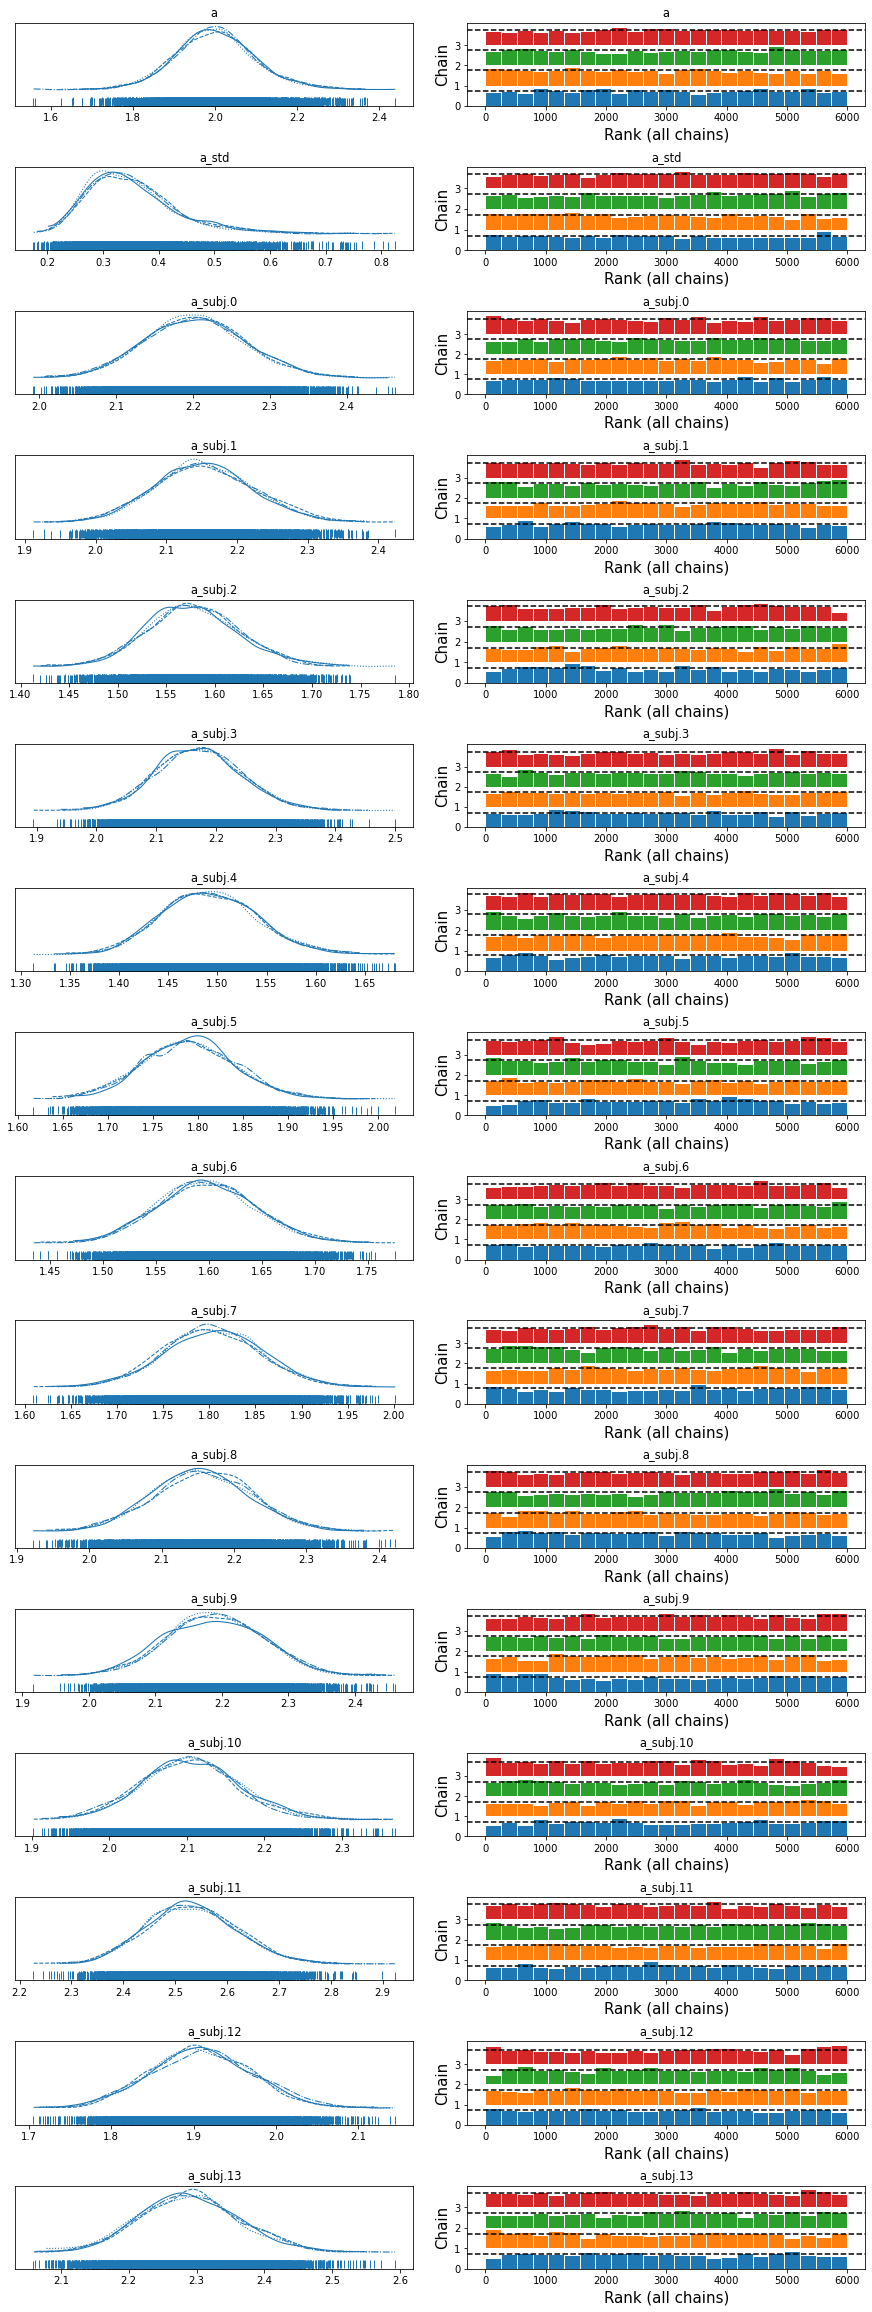

In [24]:
az.plot_trace(InfData_stim, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07b6992890>],
      dtype=object)

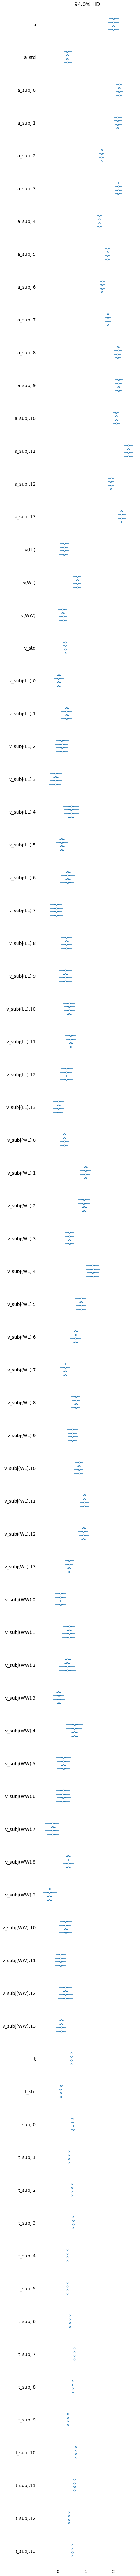

In [25]:
az.plot_forest(InfData_stim)

In [26]:
az.hdi(InfData_stim)

<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables: (12/78)
    a              (hdi) float64 1.828 2.206
    a_std          (hdi) float64 0.2132 0.506
    a_subj.0       (hdi) float64 2.086 2.333
    a_subj.1       (hdi) float64 2.031 2.287
    a_subj.2       (hdi) float64 1.492 1.669
    a_subj.3       (hdi) float64 2.034 2.304
    ...             ...
    t_subj.8       (hdi) float64 0.4939 0.5898
    t_subj.9       (hdi) float64 0.3256 0.3975
    t_subj.10      (hdi) float64 0.6208 0.6925
    t_subj.11      (hdi) float64 0.5618 0.6519
    t_subj.12      (hdi) float64 0.3726 0.4227
    t_subj.13      (hdi) float64 0.4756 0.5767

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07b78e1f50>,
      dtype=object)

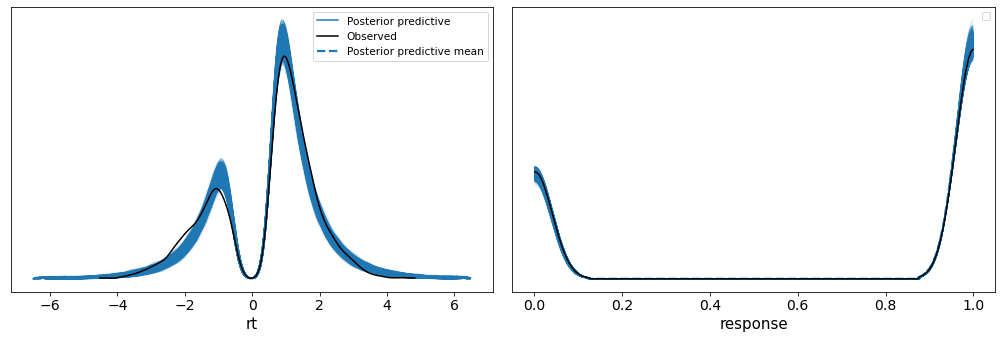

In [27]:
az.plot_ppc(InfData_stim)

### Tried to draw from prior (failed)

In [29]:
tmp = m_stim_list[0]
tmp.draw_from_prior(tmp, update=False)
# tmp.draw_from_prior(update=False)

TypeError: draw_from_prior() got multiple values for argument 'update'

In [30]:
df_stim_priors = []
for i in range(4):
    df = m_stim_list[i]
    df_prior = df.draw_from_prior()
    df_prior['chain'] = i
    df_prior['draw'] = np.arange(len(df_prior), dtype=int)
    print('chain', i, df_prior.shape)
    df_priors.append(df_trace)
df_stim_priors = pd.concat(df_stim_priors)
df_stim_priors = df_stim_priors.set_index(["chain", "draw"])

AttributeError: Deterministic a_rate's value cannot be set.

### tried `loo` and `waic`

In [545]:
az.loo(InfData_stim)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:809: RuntimeWarning: invalid value encountered in subtract
  x -= np.max(x)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats_utils.py:323: RuntimeWarning: invalid value encountered in subtract
  ary -= ary_max


Computed from 6000 by 6594 log-likelihood matrix

         Estimate       SE
elpd_loo      nan      nan
p_loo         nan        -

There has been a warning during the calculation. Please check the results.

In [546]:
az.waic(InfData_stim)

Computed from 6000 by 6594 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

There has been a warning during the calculation. Please check the results.